In [12]:
!pip install optuna

In [28]:
import optuna
from optuna import Trial
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
import xgboost as xgb
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# **Data inspection and preprocessing**

In [14]:
# Unpacking data from pickle file and basic information about the data
data = pd.read_pickle('./ass3.pickle')
train, dev, test = data['train'], data['dev'], data['test']

In [15]:
# Show basic data information
print(f"number of features: {len(train.columns) - 1}")
print(f"types of labels: {train['target'].unique()}")
print(f"number of different values: {[(c,len(train[c].unique()))  for c in train]}")
print(f"number of rows in train: {len(train)}")
print(f"number of rows in dev: {len(dev)}")
print(f"number of rows in test: {len(test)}")


number of features: 8
types of labels: [1.695 2.796 1.322 ... 3.508 4.321 2.355]
number of different values: [('f0', 8588), ('f1', 53), ('f2', 11722), ('f3', 9386), ('f4', 3305), ('f5', 11485), ('f6', 799), ('f7', 783), ('target', 3391)]
number of rows in train: 12384
number of rows in dev: 4128
number of rows in test: 4128


In [16]:
#Checking for missing values
train.isnull().sum()
train = train.dropna()
train

,f0,f1,f2,f3,f4,f5,f6,f7,target
14981,4.0391,15.0,6.297710,0.992366,334.0,2.549618,32.72,-116.99,1.695
6614,4.7241,46.0,5.375758,0.954545,753.0,2.281818,34.17,-118.10,2.796
14233,3.3553,7.0,5.229213,1.101124,1304.0,2.930337,32.70,-117.01,1.322
1802,1.3929,52.0,5.000000,0.953488,126.0,2.930233,37.92,-122.36,1.042
6030,1.6006,52.0,4.427083,1.017361,1246.0,2.163194,34.07,-117.75,1.462
...,...,...,...,...,...,...,...,...,...
1377,3.8824,37.0,5.049275,0.982609,1128.0,3.269565,38.02,-122.09,1.137
7250,2.5395,26.0,4.528600,1.053254,1777.0,3.504931,33.99,-118.12,1.910
17934,3.6118,48.0,4.387324,1.035211,697.0,2.454225,37.35,-121.95,2.355
1355,3.5436,16.0,5.013825,1.069124,1410.0,3.248848,38.03,-121.92,1.002


In [17]:
# Show general information about the data (mean, ste, etc. by feature)
train.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,target
count,11146.000000,11146.000000,11146.000000,11146.000000,11146.000000,11146.000000,11146.000000,11146.000000,11146.000000
mean,3.879911,28.518841,5.435400,1.098660,1428.847389,3.117393,35.626729,-119.561998,2.070301
std,1.917411,12.554143,2.450915,0.489939,1104.163812,13.263232,2.136671,1.998680,1.147234
min,0.499900,1.000000,0.846154,0.500000,3.000000,0.692308,32.550000,-124.350000,0.149990
25%,2.558900,18.000000,4.433962,1.006135,788.000000,2.428343,33.930000,-121.790000,1.202000
50%,3.543100,29.000000,5.221985,1.049440,1170.000000,2.816541,34.250000,-118.490000,1.804000
75%,4.753600,37.000000,6.049334,1.099461,1745.750000,3.272933,37.710000,-118.020000,2.653000
max,15.000100,52.000000,132.533333,34.066667,28566.000000,1243.333333,41.950000,-114.550000,5.000010


In [18]:
# Information about the training data - group by label
train.groupby('target').describe()

f0                                                            \
         count      mean       std     min       25%      50%        75%   
target                                                                     
0.14999    2.0  1.098350  0.795283  0.5360  0.817175  1.09835   1.379525   
0.17500    1.0  2.366700       NaN  2.3667  2.366700  2.36670   2.366700   
0.25000    1.0  0.857100       NaN  0.8571  0.857100  0.85710   0.857100   
0.27500    1.0  1.265600       NaN  1.2656  1.265600  1.26560   1.265600   
0.28300    1.0  2.737700       NaN  2.7377  2.737700  2.73770   2.737700   
...        ...       ...       ...     ...       ...      ...        ...   
4.98800    1.0  8.248000       NaN  8.2480  8.248000  8.24800   8.248000   
4.99000    1.0  8.148900       NaN  8.1489  8.148900  8.14890   8.148900   
4.99100    1.0  6.786100       NaN  6.7861  6.786100  6.78610   6.786100   
5.00000   15.0  3.472600  1.307130  1.2656  2.481950  3.61210   4.352100   
5.00001  503.0  8.028735  3.292247  0.4999  5.373000  7.89970  10.229050   

                     f1            ...      f6            f7              \
             max  count      mean  ...     75%    max  count        mean   
target                             ...                                     
0.14999   1.6607    2.0  26.00000  ...  40.160  40.31    2.0 -122.955000   
0.17500   2.3667    1.0  39.00000  ...  34.150  34.15    1.0 -118.330000   
0.25000   0.8571    1.0  21.00000  ...  32.790  32.79    1.0 -114.650000   
0.27500   1.2656    1.0  17.00000  ...  33.920  33.92    1.0 -114.670000   
0.28300   2.7377    1.0  29.00000  ...  34.700  34.70    1.0 -120.590000   
...          ...    ...       ...  ...     ...    ...    ...         ...   
4.98800   8.2480    1.0  29.00000  ...  37.330  37.33    1.0 -122.060000   
4.99000   8.1489    1.0  18.00000  ...  37.890  37.89    1.0 -122.180000   
4.99100   6.7861    1.0  28.00000  ...  33.550  33.55    1.0 -117.770000   
5.00000   6.0199   15.0  35.60000  ...  37.635  37.80   15.0 -119.902667   
5.00001  15.0001  503.0  33.40159  ...  37.380  37.98  503.0 -119.667654   

                                                                
              std     min       25%      50%       75%     max  
target                                                          
0.14999  0.304056 -123.17 -123.0625 -122.955 -122.8475 -122.74  
0.17500       NaN -118.33 -118.3300 -118.330 -118.3300 -118.33  
0.25000       NaN -114.65 -114.6500 -114.650 -114.6500 -114.65  
0.27500       NaN -114.67 -114.6700 -114.670 -114.6700 -114.67  
0.28300       NaN -120.59 -120.5900 -120.590 -120.5900 -120.59  
...           ...     ...       ...      ...       ...     ...  
4.98800       NaN -122.06 -122.0600 -122.060 -122.0600 -122.06  
4.99000       NaN -122.18 -122.1800 -122.180 -122.1800 -122.18  
4.99100       NaN -117.77 -117.7700 -117.770 -117.7700 -117.77  
5.00000  2.141043 -122.49 -122.4400 -118.480 -118.2300 -117.38  
5.00001  1.911683 -122.56 -122.0900 -118.490 -118.3400 -116.55  

[3311 rows x 64 columns]

In [33]:
# Splitting the data into features and labels dataframes
train_features, train_labels = train.drop('target', axis=1), train['target']
dev_features, dev_labels = dev.drop('target', axis=1), dev['target']
test_features, test_labels = test.drop('target', axis=1), test['target']

<Axes: >

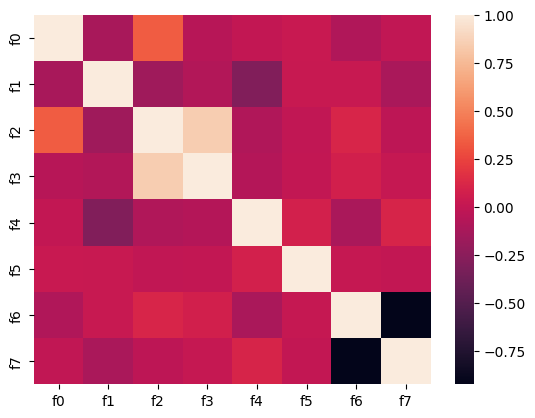

In [20]:
# Check for redundant feature. We decide against removing features since the correlations are not strong enough
sns.heatmap(train_features.corr())

In [21]:
train_features

,f0,f1,f2,f3,f4,f5,f6,f7
14981,4.0391,15.0,6.297710,0.992366,334.0,2.549618,32.72,-116.99
6614,4.7241,46.0,5.375758,0.954545,753.0,2.281818,34.17,-118.10
14233,3.3553,7.0,5.229213,1.101124,1304.0,2.930337,32.70,-117.01
1802,1.3929,52.0,5.000000,0.953488,126.0,2.930233,37.92,-122.36
6030,1.6006,52.0,4.427083,1.017361,1246.0,2.163194,34.07,-117.75
...,...,...,...,...,...,...,...,...
1377,3.8824,37.0,5.049275,0.982609,1128.0,3.269565,38.02,-122.09
7250,2.5395,26.0,4.528600,1.053254,1777.0,3.504931,33.99,-118.12
17934,3.6118,48.0,4.387324,1.035211,697.0,2.454225,37.35,-121.95
1355,3.5436,16.0,5.013825,1.069124,1410.0,3.248848,38.03,-121.92


We use PCA to get better understanding of the data:

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2))
pca.fit(train_features)
pca_train_features = pd.DataFrame(pca.transform(train_features), columns=[f'PCA{i}' for i in range(2)])
pca_train_features

,PCA0,PCA1
0,-1.195277,1.374442
1,-0.736618,0.091041
2,-1.496387,1.416940
3,1.259177,-2.184761
4,-1.193586,-0.442399
...,...,...
11141,1.183886,-1.381305
11142,-1.133400,0.273902
11143,0.960789,-1.631768
11144,1.130001,-0.834284


<Axes: xlabel='PCA0', ylabel='PCA1'>

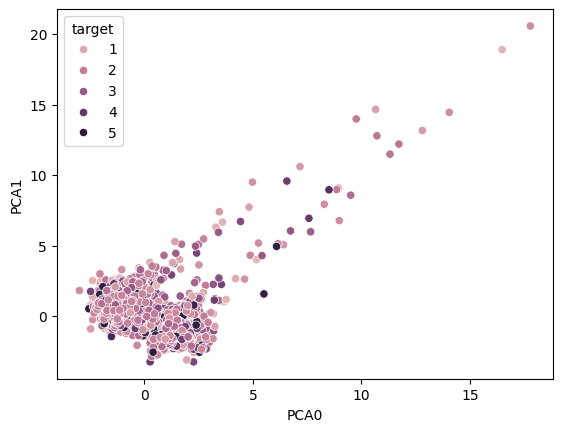

In [23]:
pca_train = pd.concat([pca_train_features, train_labels], ignore_index=True, axis=1)
pca_train.columns = ['PCA0','PCA1','target']
sns.scatterplot(data=pca_train, x='PCA0', y='PCA1', hue='target')

# Learning

We try few models, and for each one we try different hyperparameters using optuna which is a hyperparameter search tool we saw in class. Finally we use mean absolute error score to evaluate the model, recalling that for this metric, the goal is to minimize the result.

In [24]:
best_models = {}

In [29]:
# Check XG Boost Regressor
# We try various learning rates, max depth and estimators
def objective(trial: Trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 250, step=50)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

    xgb_reg = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        objective='reg:squarederror',
        use_label_encoder=False,
        eval_metric='rmse'
    )

    xgb_reg.fit(train_features, train_labels)
    pred = xgb_reg.predict(dev_features)
    return metrics.mean_squared_error(dev_labels, pred)

xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(objective, n_trials=100)
xgb_best_params = xgb_study.best_params

best_xgb = xgb.XGBRegressor(
    n_estimators=xgb_best_params['n_estimators'],
    max_depth=xgb_best_params['max_depth'],
    learning_rate=xgb_best_params['learning_rate'],
    objective='reg:squarederror',
    use_label_encoder=False,
    eval_metric='rmse'
)

best_xgb.fit(train_features, train_labels)
best_models[xgb_study.best_value] = best_xgb
print(f'Best XGB MSE: {xgb_study.best_value}')

[I 2024-07-15 10:04:39,221] A new study created in memory with name: no-name-0b274758-38de-4c79-bfaf-52b53a4061f3
[I 2024-07-15 10:04:40,076] Trial 0 finished with value: 0.27432977573069867 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01854578368453865}. Best is trial 0 with value: 0.27432977573069867.
[I 2024-07-15 10:04:42,226] Trial 1 finished with value: 0.23741397725850286 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.0991295066019723}. Best is trial 1 with value: 0.23741397725850286.
[I 2024-07-15 10:04:42,818] Trial 2 finished with value: 0.2383241531210696 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.0580589370444664}. Best is trial 1 with value: 0.23741397725850286.
[I 2024-07-15 10:04:43,429] Trial 3 finished with value: 0.23960866491538904 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.06347702716414062}. Best is trial 1 with value: 0.23741397725850286.
[I 2024-07-1

Best XGB MSE: 0.21056875722800356


In [25]:
# Check Random Forest Regressor
# We try various depth, estimators and minimal split parameters
from sklearn.ensemble import RandomForestRegressor
def objective(trial: Trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 250, step=50)
    max_depth = trial.suggest_categorical('max_depth', [None, 30, 50])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 3, 4])
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    rf.fit(train_features, train_labels)
    pred = rf.predict(dev_features)
    return metrics.mean_squared_error(pred, dev_labels)

rf_study = optuna.create_study(direction='minimize')
rf_study.optimize(objective, n_trials=100)
rf_best_params = rf_study.best_params
best_rf = RandomForestRegressor(n_estimators=rf_best_params['n_estimators'], max_depth=rf_best_params['max_depth'], min_samples_split=rf_best_params['min_samples_split'])
best_rf.fit(train_features, train_labels)
best_models[rf_study.best_value] = best_rf
print(f'Best RF MAE: {rf_study.best_value}')

[I 2024-07-15 09:31:18,712] A new study created in memory with name: no-name-85caf1c9-e43c-498b-8dc5-de045a99a203
[I 2024-07-15 09:31:35,085] Trial 0 finished with value: 0.2710164952815912 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 4}. Best is trial 0 with value: 0.2710164952815912.
[I 2024-07-15 09:32:09,499] Trial 1 finished with value: 0.27070843543208967 and parameters: {'n_estimators': 250, 'max_depth': 30, 'min_samples_split': 2}. Best is trial 1 with value: 0.27070843543208967.
[I 2024-07-15 09:32:31,562] Trial 2 finished with value: 0.27118542910051047 and parameters: {'n_estimators': 250, 'max_depth': 30, 'min_samples_split': 3}. Best is trial 1 with value: 0.27070843543208967.
[I 2024-07-15 09:32:44,656] Trial 3 finished with value: 0.272558052673315 and parameters: {'n_estimators': 150, 'max_depth': None, 'min_samples_split': 4}. Best is trial 1 with value: 0.27070843543208967.
[I 2024-07-15 09:32:58,719] Trial 4 finished with value: 0.27130

Best RF MAE: 0.2688315547978513


In [26]:
# Check Linear Regression
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_features, train_labels)
pred = reg.predict(dev_features)
best_models[metrics.mean_squared_error(pred, dev_labels)]=reg
print(f'Best Linear Regression MAE: {metrics.mean_squared_error(pred, dev_labels)}')

Best Linear Regression MAE: 0.5197408703272494


In [34]:
# Check SVM
# We try few possible parameters
from sklearn import svm
def objective(trial: Trial):
    degree = trial.suggest_int('degree', 1, 4, step=1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])
    C = trial.suggest_float('C', 0.5, 2)
    svr = svm.SVR(kernel=kernel, degree=degree, C=C, gamma=gamma)
    # Training on all examples is too slow
    svr.fit(train_features[:5000,:], train_labels[:5000,:])
    pred = svr.predict(dev_features)
    return metrics.mean_squared_error(pred, dev_labels)

svr_study = optuna.create_study(direction='minimize')
svr_study.optimize(objective, n_trials=100)
svr_best_params = svr_study.best_params
best_svr = svm.SVR(kernel=svr_best_params['kernel'], gamma=svr_best_params['gamma'], C=svr_best_params['C'], degree=svr_best_params['degree'])

# After choosing the hyper-parameters, train on all samples
best_svr.fit(train_features, train_labels)
best_models[svr_study.best_value] = best_svr
print(f'Best SVR MAE: {svr_study.best_value}')

[I 2024-07-15 10:57:45,176] A new study created in memory with name: no-name-8f6abdef-2aa0-40ae-8bf1-dc1b2e1bc3a2
[W 2024-07-15 10:57:45,182] Trial 0 failed with parameters: {'degree': 4, 'gamma': 'auto', 'kernel': 'poly', 'C': 0.689781635961545} because of the following error: InvalidIndexError((slice(None, 5000, None), slice(None, None, None))).
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 153, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(slice(None, 5000, None), slice(None, None, None))' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_v

InvalidIndexError: (slice(None, 5000, None), slice(None, None, None))

# Test

We found that XG boost regressor is the best model of the ones we checked. We will use it on the test data and print the accuracy:

In [35]:
best_mae = float('inf')
best_model = None
for mae in best_models:
  if mae < best_mae:
    best_mae = mae
    best_model = best_models[mae]

print(f'Best model is: {best_model}')
print(f'Best MAE for test: {metrics.mean_squared_error(best_model.predict(test_features), test_labels)}')

Best model is: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09909430003768718,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Best MAE for test: 0.22031977283033732
